In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# model = models.resnet50(pretrained=True)
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0')  

Loaded pretrained weights for efficientnet-b0


In [4]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
from torch.utils.data import random_split

data = datasets.ImageFolder(r'C:\Users\Sai Krishna\Desktop\Saketh\archive\bloodcells_dataset', transform=transform)
train_len = int(0.8 * len(data))  # 80% of the data for training
test_len = len(data) - train_len  # 20% of the data for testing
train_data, test_data = random_split(data, [train_len, test_len])
print(len(train_data))
print(len(test_data))

# train_data = datasets.ImageFolder('./data/train', transform=transform)
# test_data = datasets.ImageFolder('./data/test', transform=transform)

13673
3419


In [6]:
train_len = int(0.85 * len(train_data))
valid_len = len(train_data) - train_len
train_data, valid_data = random_split(train_data, [train_len, valid_len])

In [7]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move your model to the chosen device
model = model.to(device)

In [9]:
# Train the model

model.train()
num_epochs = 50
patience = 20
best_valid_loss = float('inf')
no_improve_epoch = 0
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_correct += torch.sum(preds == labels.data)
        batch_loss = loss.item() * inputs.size(0) / len(train_loader.dataset)
        batch_accuracy = torch.sum(preds == labels.data).double() / len(inputs)
        # print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}.. Training Loss: {batch_loss:.3f}.. Training Accuracy: {batch_accuracy:.3f}')
    train_accuracy = train_correct.double().item() / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    for batch_idx, (inputs, labels) in enumerate(valid_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * inputs.size(0)
        valid_correct += torch.sum(preds == labels.data)
        batch_loss = loss.item() * inputs.size(0) / len(valid_loader.dataset)
        batch_accuracy = torch.sum(preds == labels.data).double() / len(inputs)
        # print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(valid_loader)}.. Validation Loss: {batch_loss:.3f}.. Validation Accuracy: {batch_accuracy:.3f}')
    valid_accuracy = valid_correct.double().item() / len(valid_loader.dataset)
    valid_accuracies.append(valid_accuracy)
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        no_improve_epoch = 0
    else:
        no_improve_epoch += 1
    if no_improve_epoch == patience:
        print('Early stopping')
        break


    print(f'Epoch: {epoch+1}/{num_epochs}.. Training Loss: {train_loss:.3f}.. Validation Loss: {valid_loss:.3f}.. Training Accuracy: {train_accuracy:.3f}.. Validation Accuracy: {valid_accuracy:.3f}')

Epoch: 1/50.. Training Loss: 0.338.. Validation Loss: 0.066.. Training Accuracy: 0.920.. Validation Accuracy: 0.974
Epoch: 2/50.. Training Loss: 0.136.. Validation Loss: 0.095.. Training Accuracy: 0.956.. Validation Accuracy: 0.966
Epoch: 3/50.. Training Loss: 0.062.. Validation Loss: 0.137.. Training Accuracy: 0.979.. Validation Accuracy: 0.957
Epoch: 4/50.. Training Loss: 0.061.. Validation Loss: 0.079.. Training Accuracy: 0.981.. Validation Accuracy: 0.975
Epoch: 5/50.. Training Loss: 0.038.. Validation Loss: 0.071.. Training Accuracy: 0.988.. Validation Accuracy: 0.979
Epoch: 6/50.. Training Loss: 0.040.. Validation Loss: 0.103.. Training Accuracy: 0.987.. Validation Accuracy: 0.967
Epoch: 7/50.. Training Loss: 0.038.. Validation Loss: 0.054.. Training Accuracy: 0.988.. Validation Accuracy: 0.981
Epoch: 8/50.. Training Loss: 0.028.. Validation Loss: 0.058.. Training Accuracy: 0.990.. Validation Accuracy: 0.981
Epoch: 9/50.. Training Loss: 0.029.. Validation Loss: 0.055.. Training A

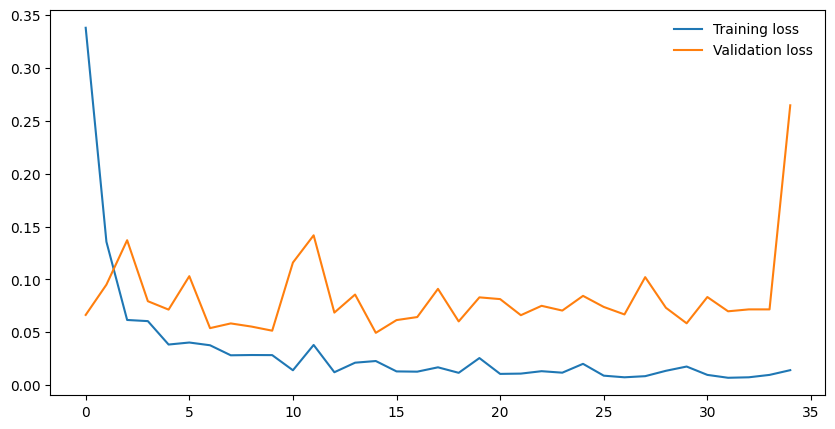

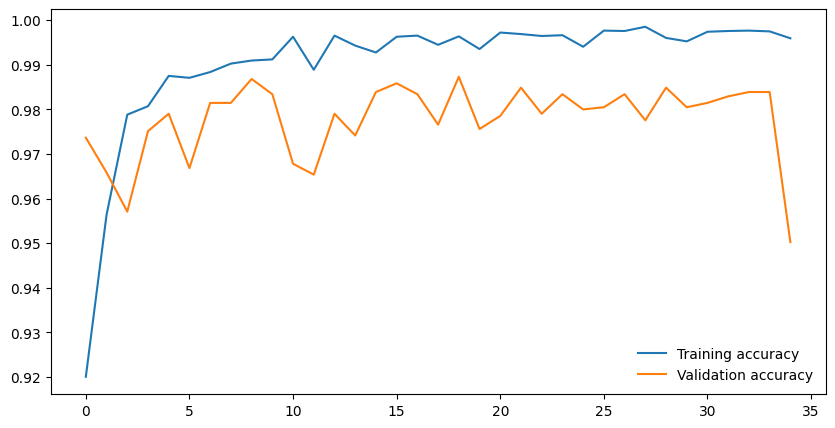

In [10]:
from sklearn.metrics import classification_report
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()



In [8]:
# Load the model
# model = models.mobilenet_v2(pretrained = False)  # Initialize the model class.
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')  # You can use 'efficientnet-b1', 'efficientnet-b2', etc. for different variants

model.load_state_dict(torch.load('efficientnet-b0.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# print("Loaded PyTorch Model State from model.pth")


print("Loaded PyTorch Model State")

Loaded pretrained weights for efficientnet-b0
Loaded PyTorch Model State


In [9]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted)
        all_labels.extend(labels)
print('Test Accuracy: %2f%%' % (100 * correct / total))

Test Accuracy: 99.444282%


In [11]:
from sklearn.metrics import classification_report
import numpy as np
all_labels = np.array([t.cpu().numpy() for t in all_labels])
all_preds = np.array([t.cpu().numpy() for t in all_preds])


classes = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

    basophil       1.00      0.99      1.00       232
  eosinophil       1.00      1.00      1.00       653
erythroblast       1.00      1.00      1.00       302
          ig       0.99      0.99      0.99       618
  lymphocyte       0.99      1.00      1.00       273
    monocyte       0.98      0.99      0.99       293
  neutrophil       0.99      0.99      0.99       603
    platelet       1.00      1.00      1.00       445

    accuracy                           0.99      3419
   macro avg       0.99      0.99      0.99      3419
weighted avg       0.99      0.99      0.99      3419



<AxesSubplot: >

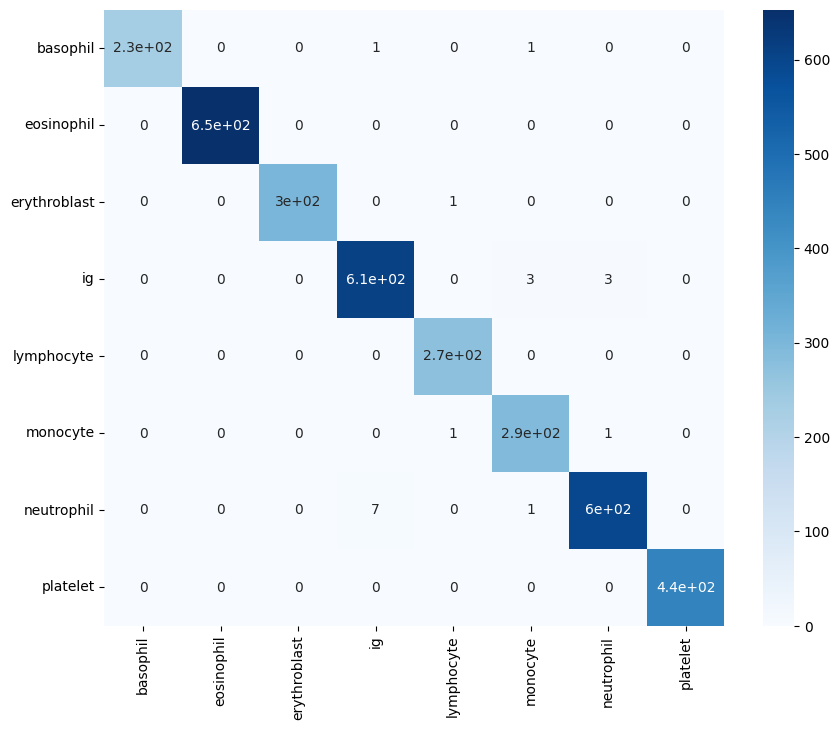

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10, 8))  
sns.heatmap(confusion_matrix(all_labels, all_preds), annot = True, cmap = 'Blues', xticklabels = classes, yticklabels = classes)

In [43]:
def extract_features_and_labels(dataloader):
    X = []
    y = []
    for images, labels in dataloader:
        images = images.to(device)
        # Pass the images to the model
        features = model(images)
        # Detach the features from the computation graph and convert to numpy arrays
        X.append(features.detach().cpu().numpy())
        # Convert the labels to numpy arrays
        y.append(labels.cpu().numpy())
    return np.concatenate(X), np.concatenate(y)

X_train, y_train = extract_features_and_labels(train_loader)
X_test, y_test = extract_features_and_labels(test_loader)

In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

def evaluate_model(X_train,y_train, X_test,y_test, model, prediction_function):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.figure(figsize=(12, 12))
    
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7])
    y_score = prediction_function(X_test)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure()
        plt.title("ROC Curve " + f"({classes[i]})")
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
    plt.show()
    
    precision = dict()
    recall = dict()
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        plt.figure()
        plt.title("Precision-Recall Curve" + f"({classes[i]})")
        plt.plot(recall[i], precision[i])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
    plt.show()

c:\Users\Sai Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9950277859023107
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       232
           1       1.00      1.00      1.00       653
           2       1.00      1.00      1.00       302
           3       0.99      0.99      0.99       618
           4       0.99      1.00      1.00       273
           5       0.99      0.99      0.99       293
           6       0.99      0.99      0.99       603
           7       1.00      1.00      1.00       445

    accuracy                           1.00      3419
   macro avg       1.00      1.00      1.00      3419
weighted avg       1.00      1.00      1.00      3419



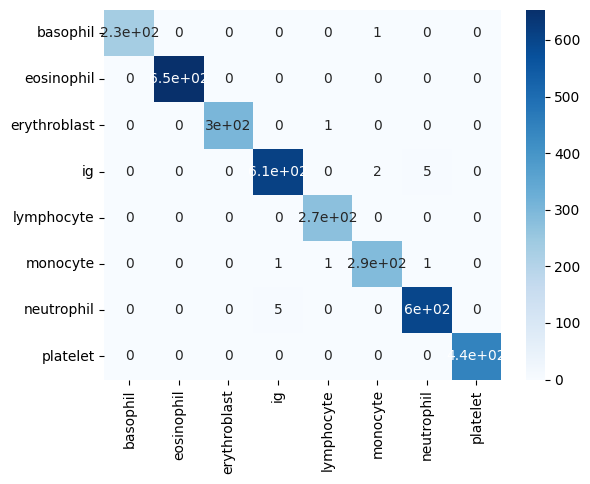

<Figure size 1200x1200 with 0 Axes>

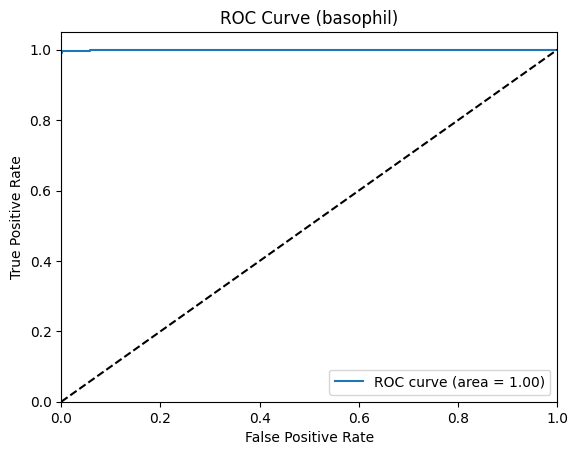

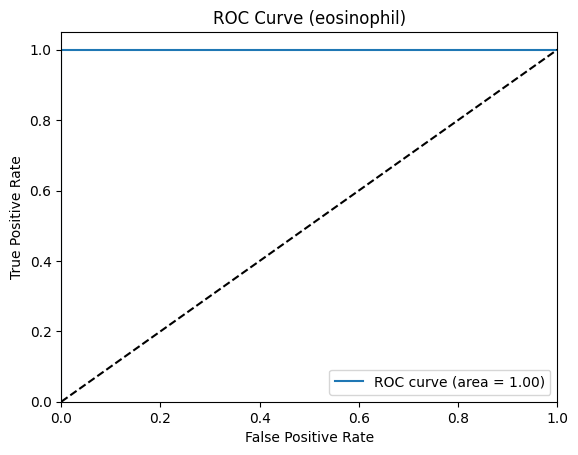

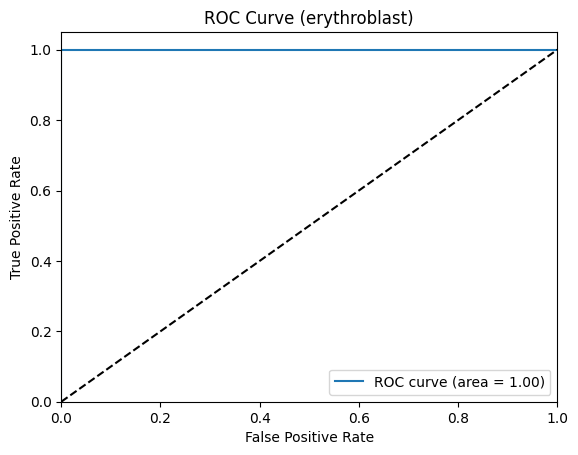

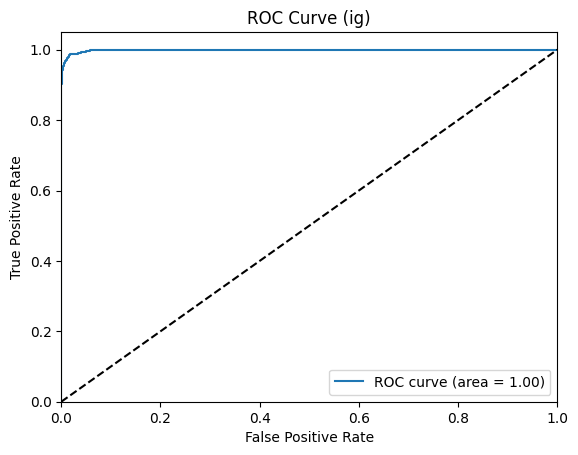

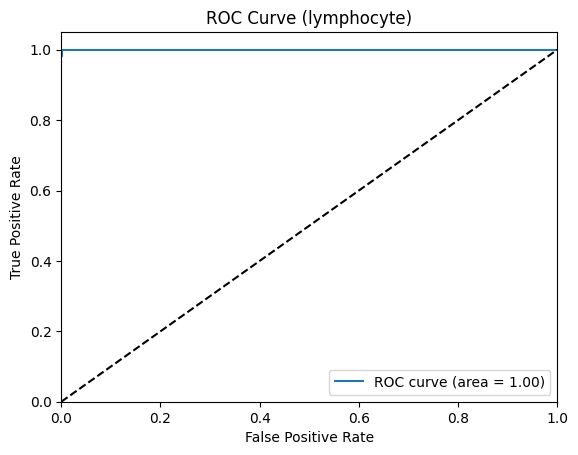

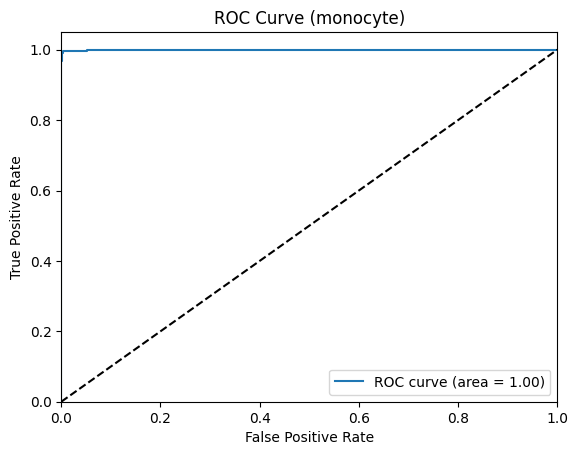

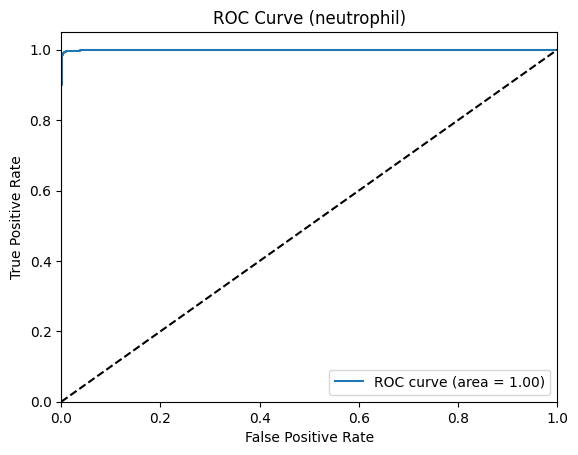

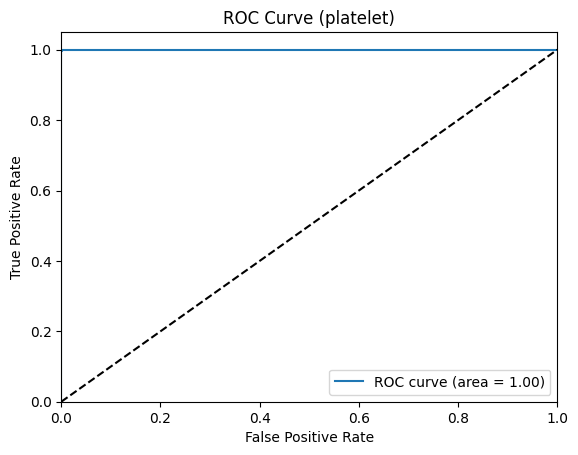

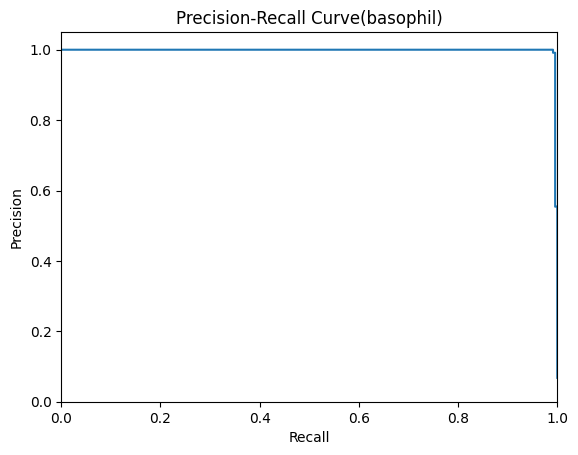

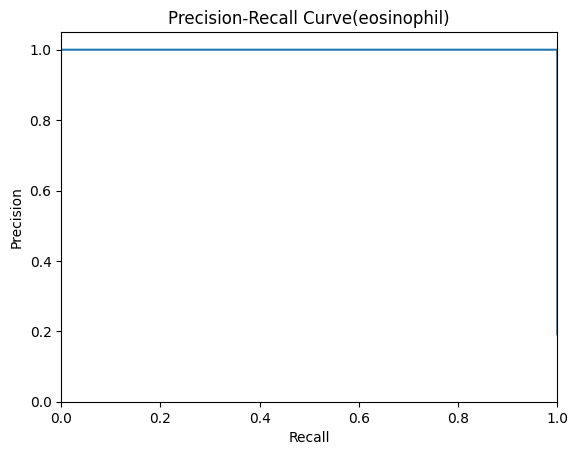

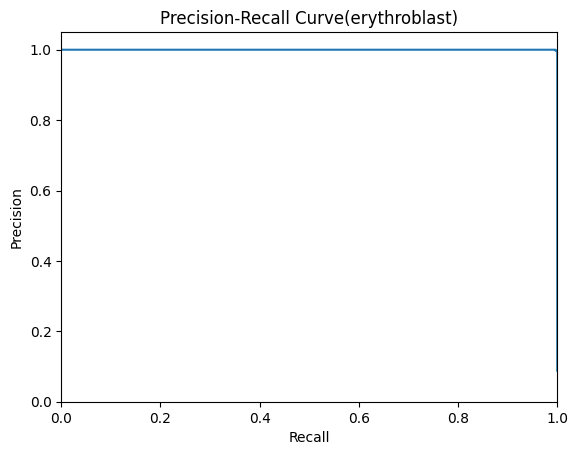

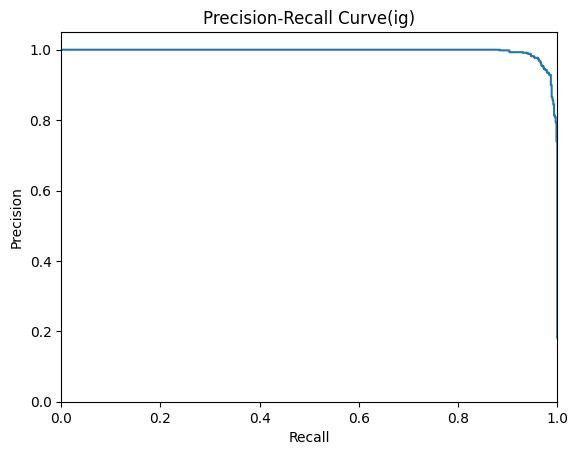

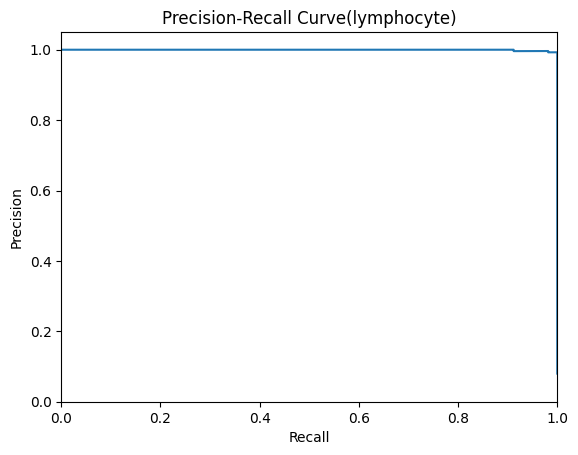

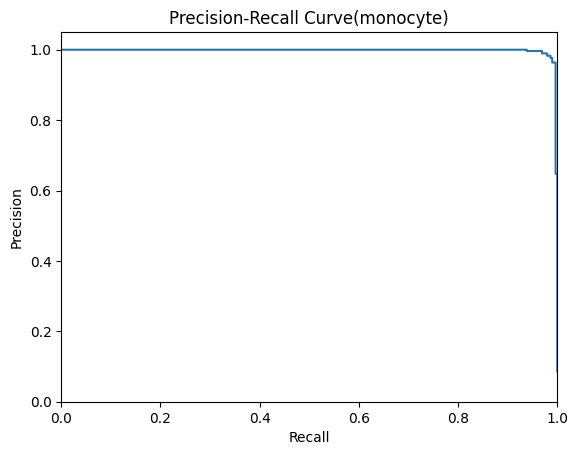

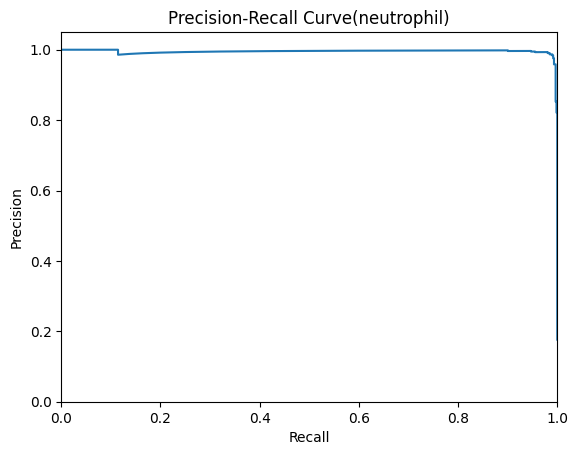

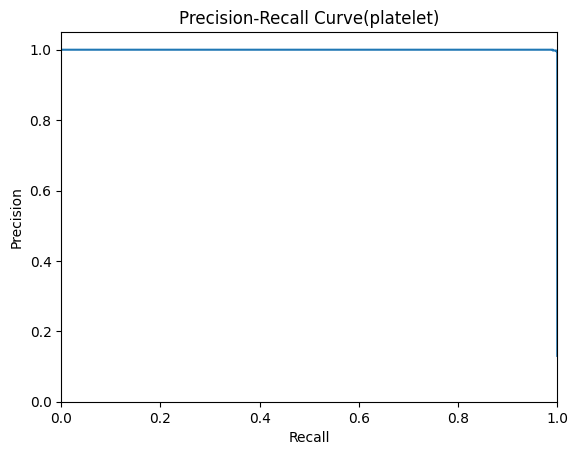

In [67]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
evaluate_model(X_train,y_train, X_test,y_test, model1, model1.decision_function)

0.9953202690845276
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       232
           1       1.00      1.00      1.00       653
           2       1.00      0.99      1.00       302
           3       0.99      0.99      0.99       618
           4       0.99      1.00      1.00       273
           5       0.99      0.99      0.99       293
           6       0.99      0.99      0.99       603
           7       1.00      1.00      1.00       445

    accuracy                           1.00      3419
   macro avg       1.00      0.99      1.00      3419
weighted avg       1.00      1.00      1.00      3419



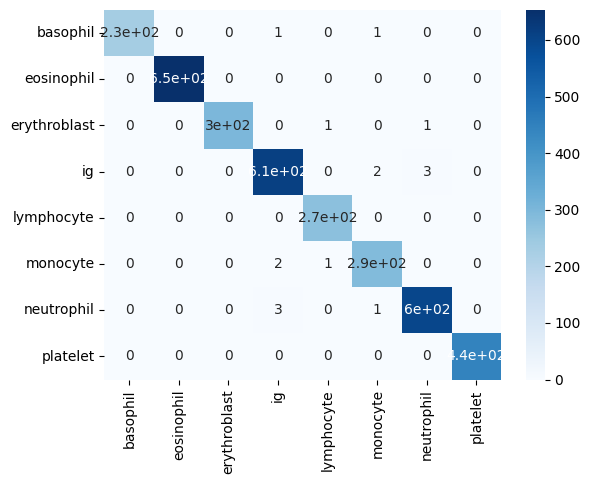

<Figure size 1200x1200 with 0 Axes>

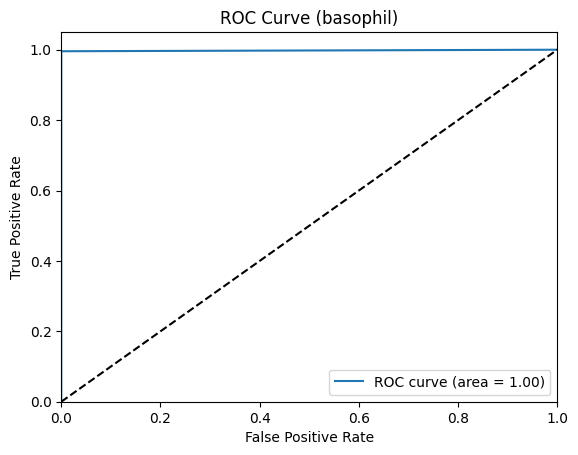

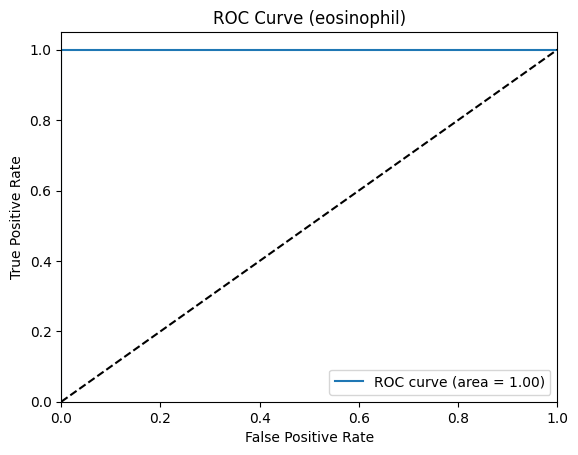

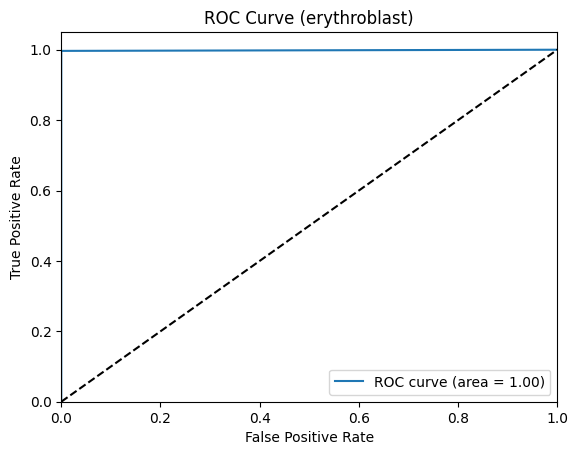

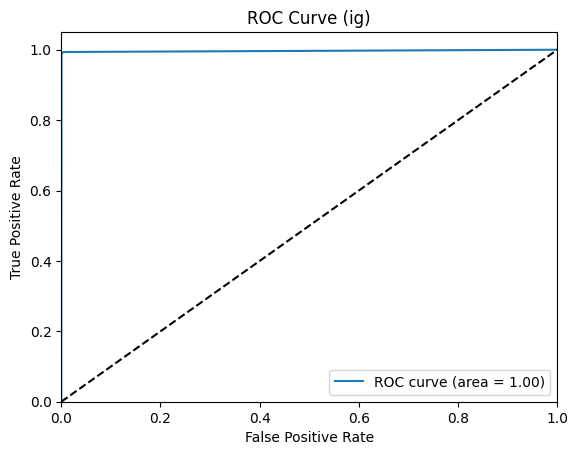

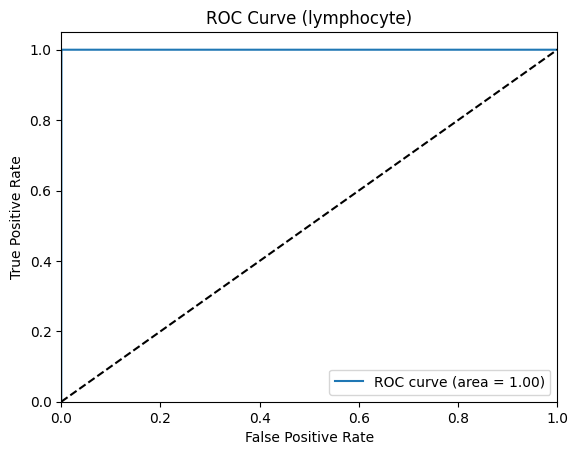

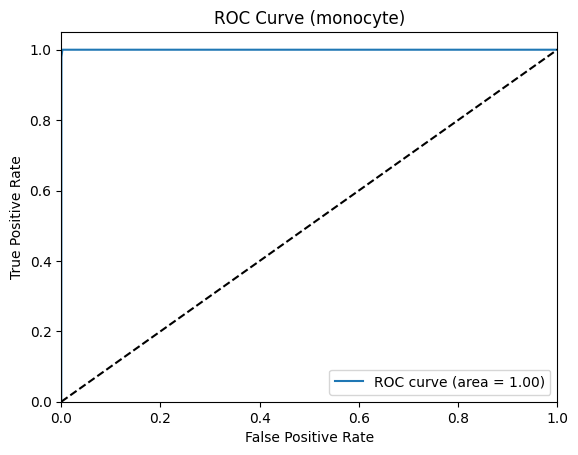

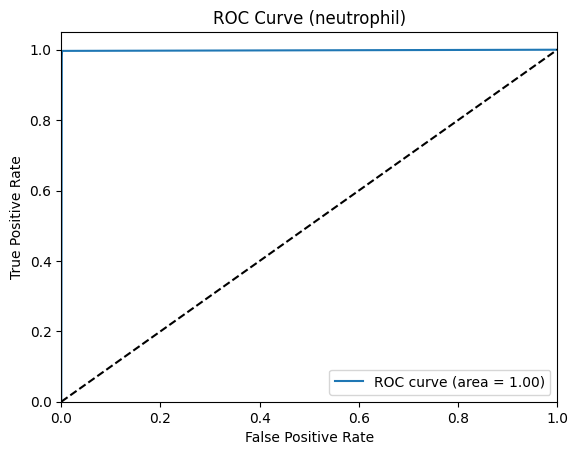

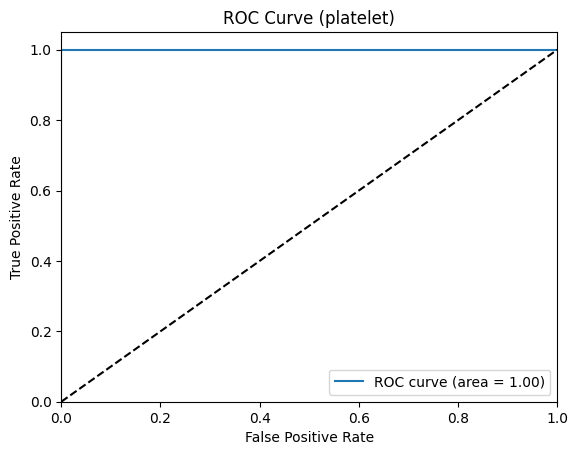

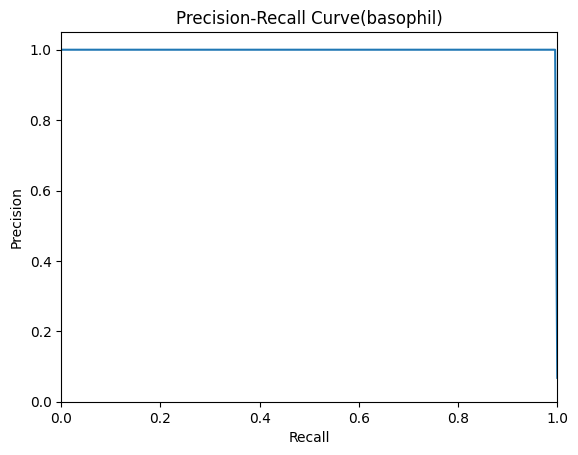

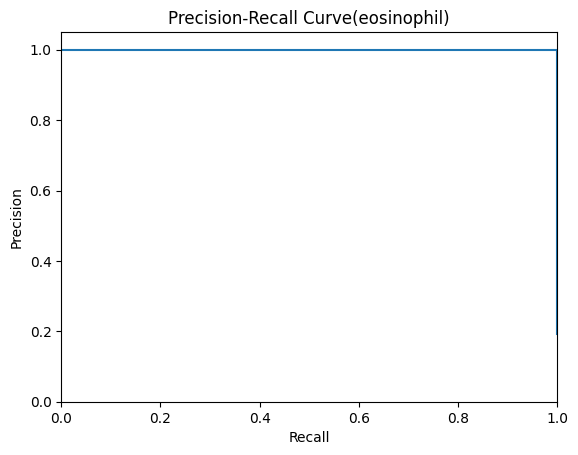

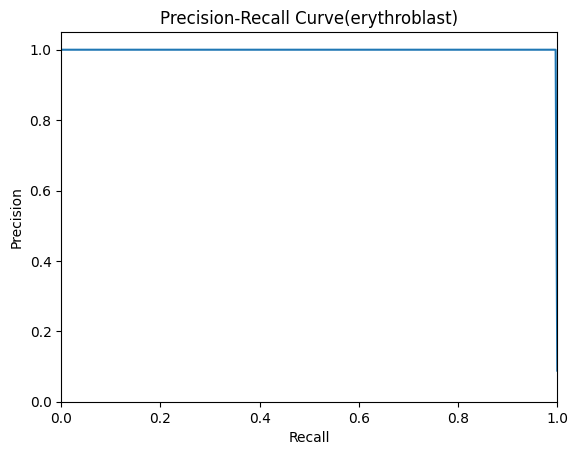

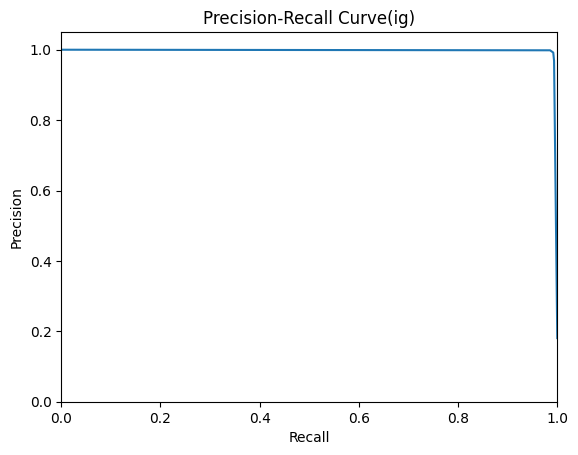

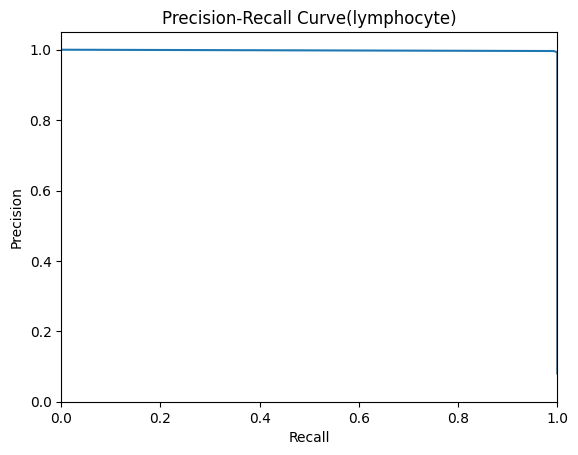

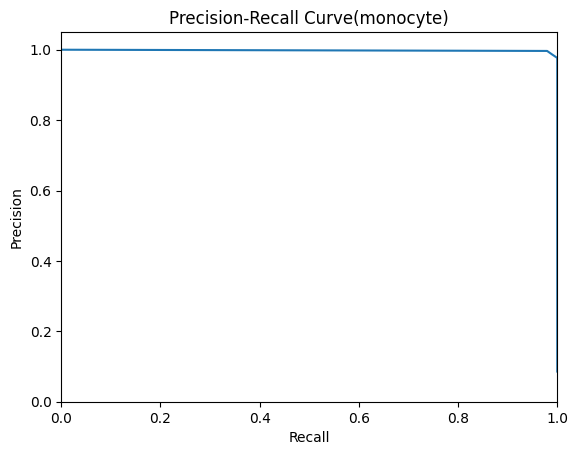

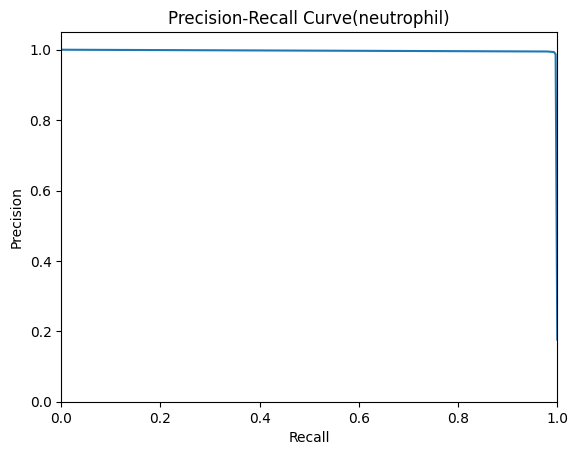

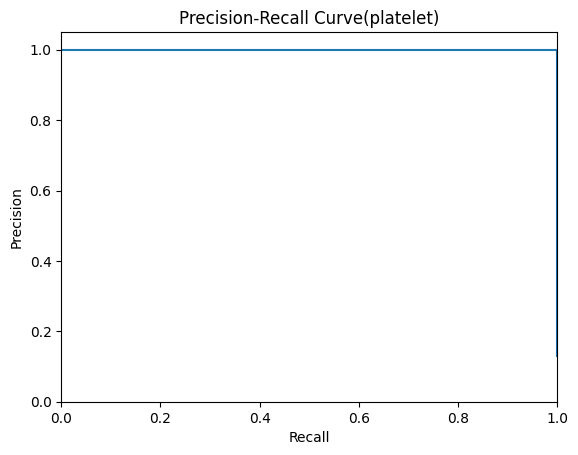

In [78]:
from sklearn.neighbors import KNeighborsClassifier
model2 = KNeighborsClassifier(n_neighbors=3)
evaluate_model(X_train,y_train, X_test,y_test, model2,model2.predict_proba )

0.9956127522667446
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       232
           1       1.00      1.00      1.00       653
           2       1.00      1.00      1.00       302
           3       0.99      1.00      0.99       618
           4       0.99      1.00      1.00       273
           5       0.99      0.99      0.99       293
           6       0.99      0.99      0.99       603
           7       1.00      1.00      1.00       445

    accuracy                           1.00      3419
   macro avg       1.00      1.00      1.00      3419
weighted avg       1.00      1.00      1.00      3419



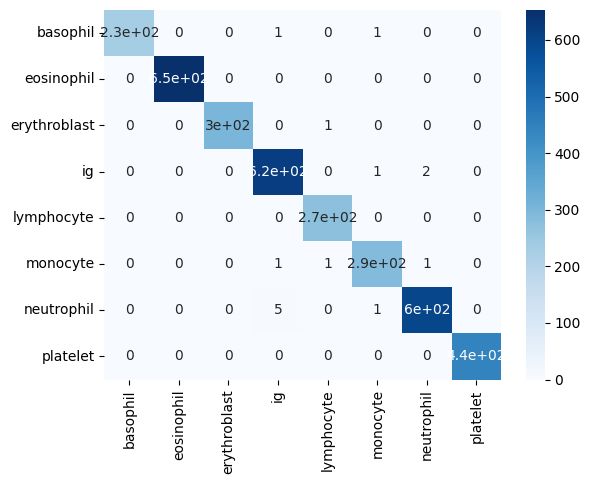

<Figure size 1200x1200 with 0 Axes>

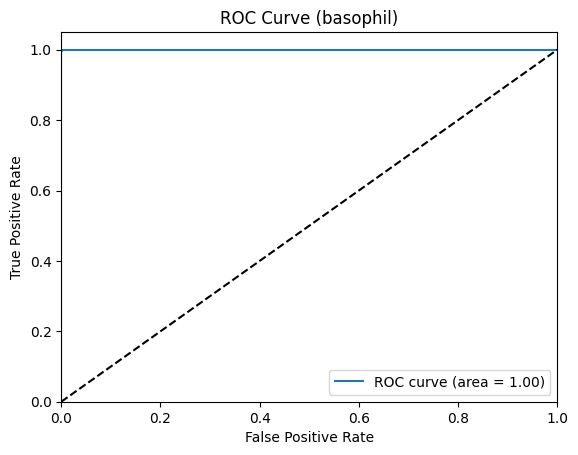

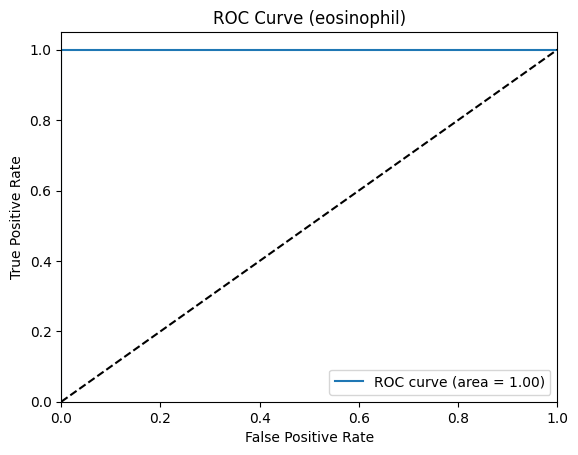

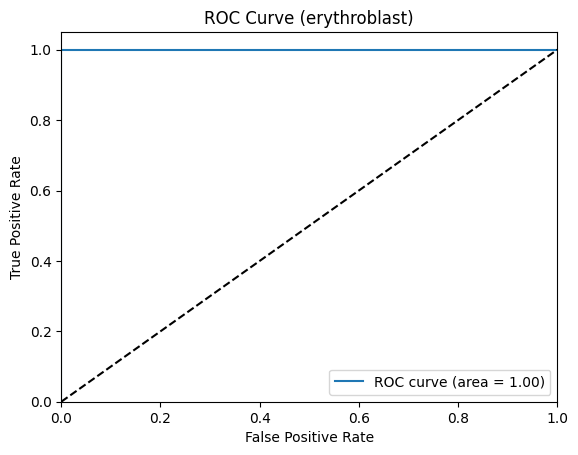

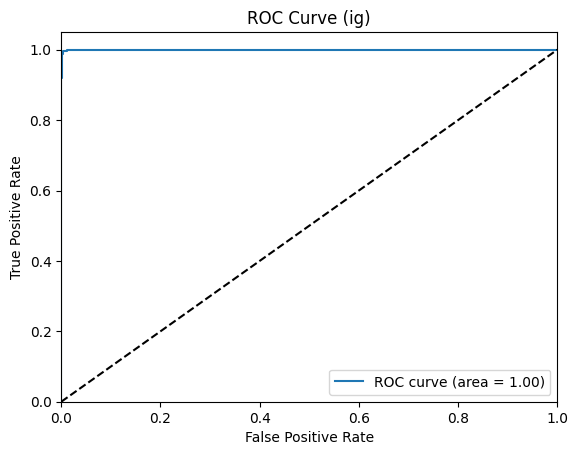

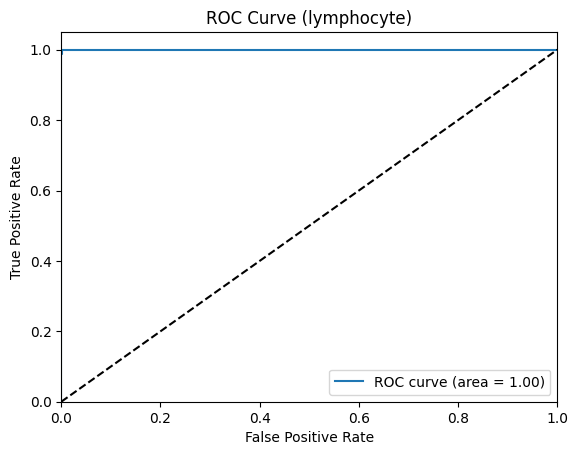

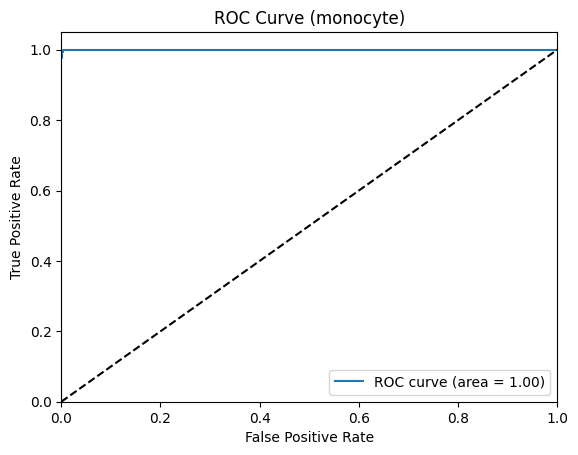

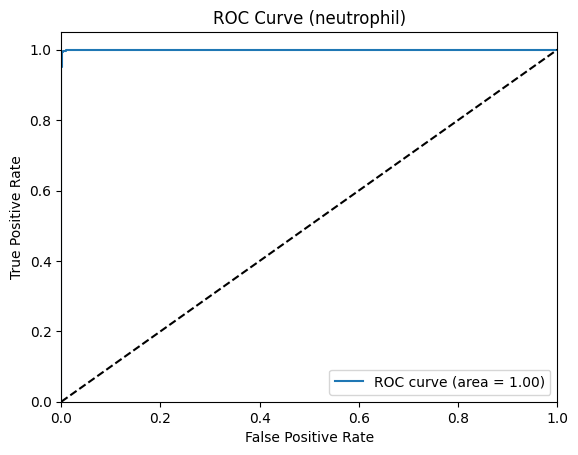

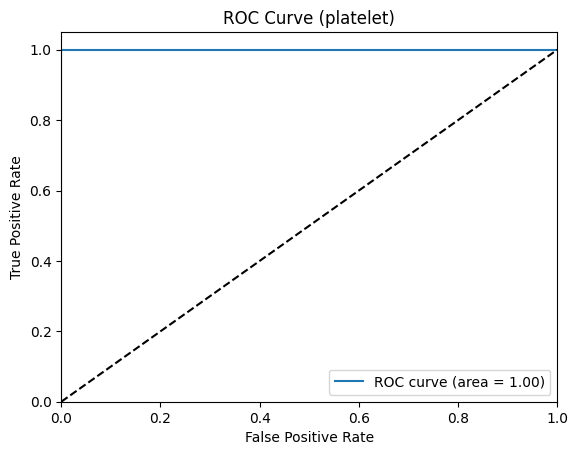

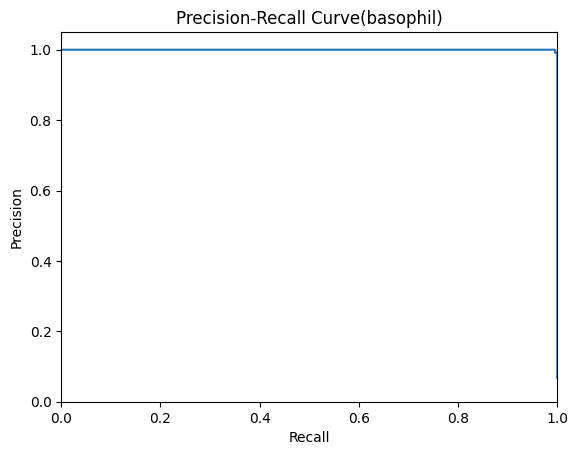

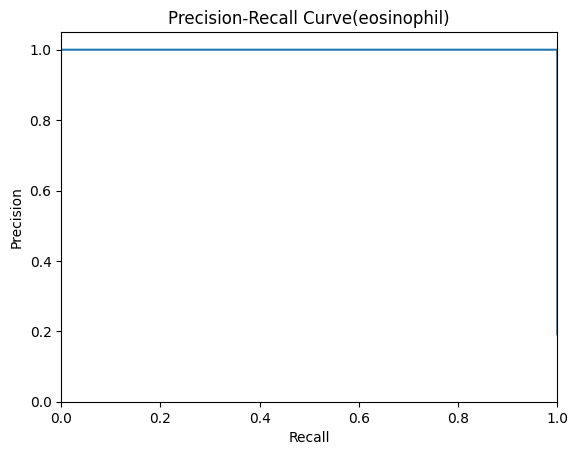

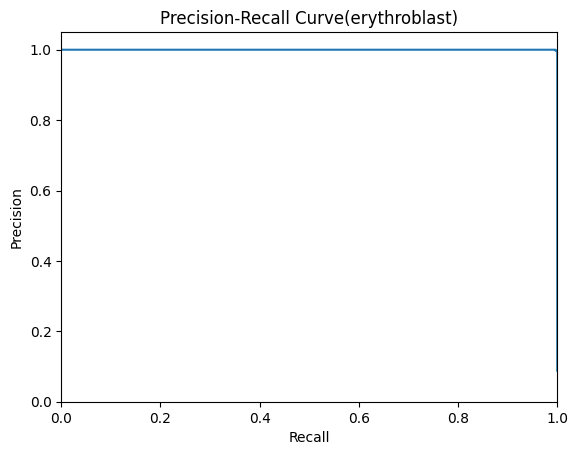

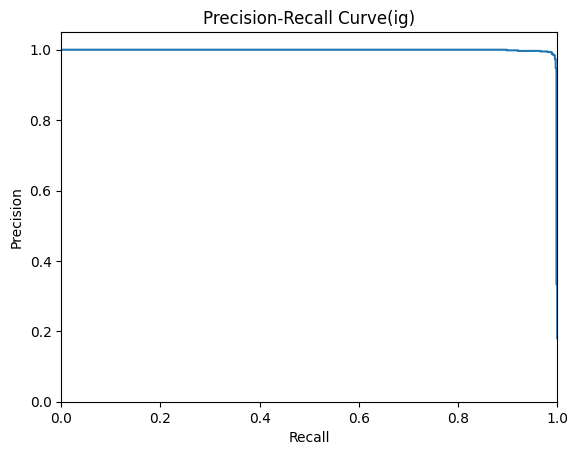

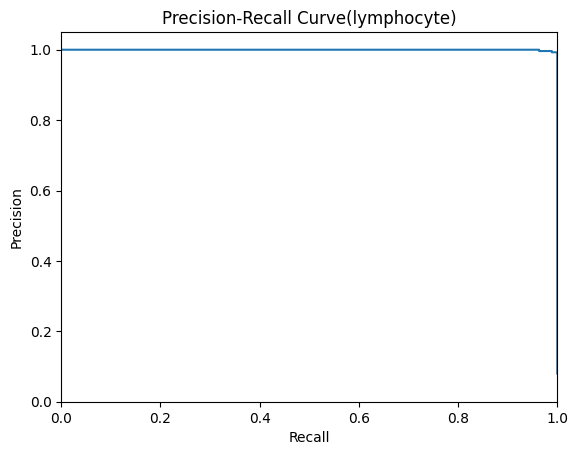

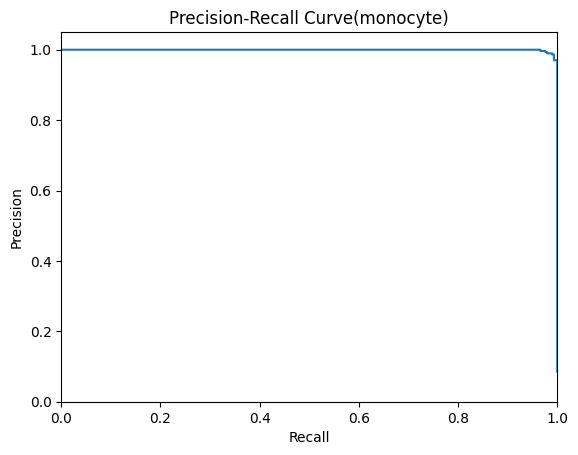

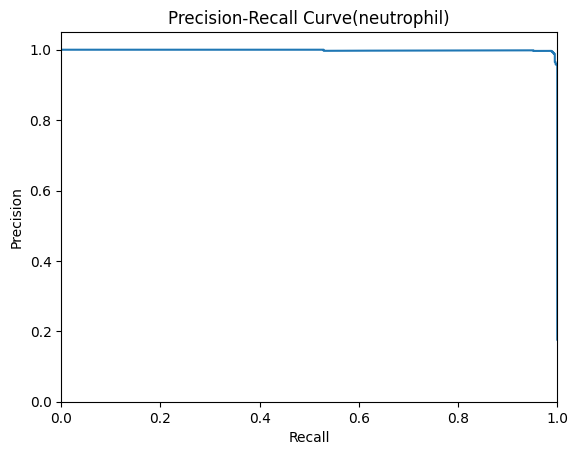

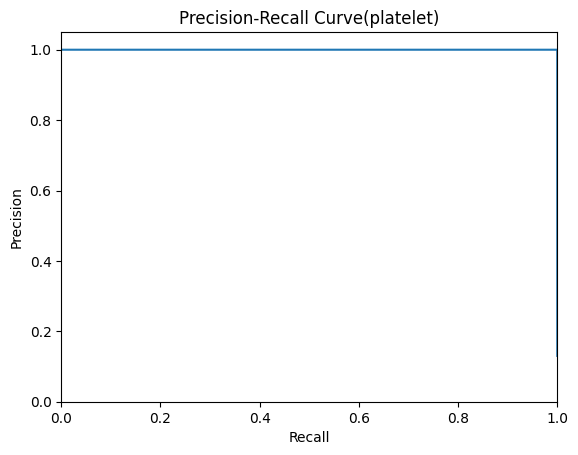

In [110]:
from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier(random_state=41, n_estimators=550, max_depth=10, min_samples_split=5)
evaluate_model(X_train,y_train, X_test,y_test, model3, model3.predict_proba)

0.9947353027200936
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       232
           1       1.00      1.00      1.00       653
           2       1.00      1.00      1.00       302
           3       0.99      0.99      0.99       618
           4       0.99      1.00      1.00       273
           5       0.99      0.99      0.99       293
           6       0.99      0.99      0.99       603
           7       1.00      1.00      1.00       445

    accuracy                           0.99      3419
   macro avg       0.99      0.99      0.99      3419
weighted avg       0.99      0.99      0.99      3419



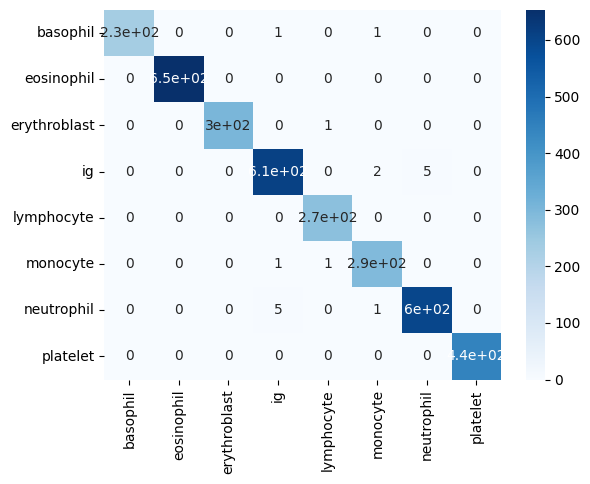

<Figure size 1200x1200 with 0 Axes>

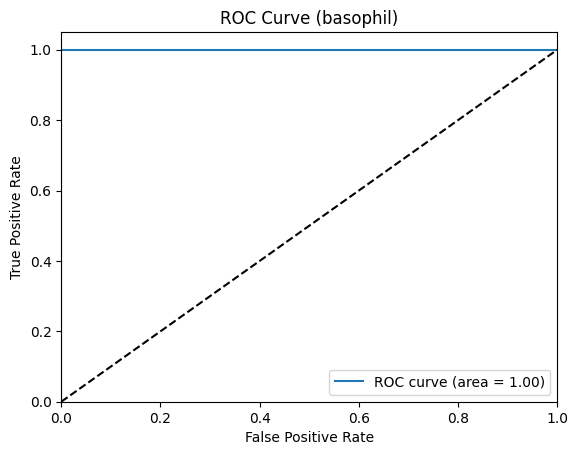

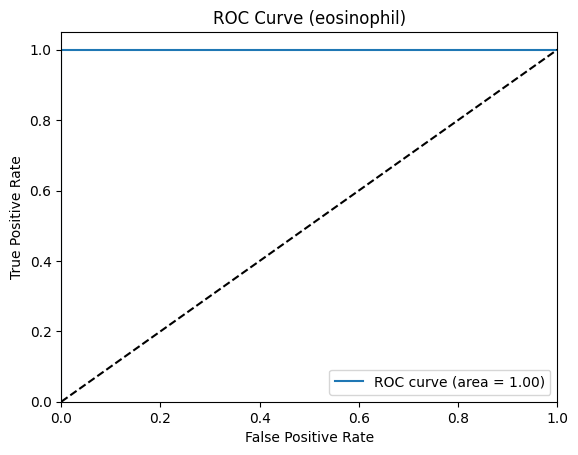

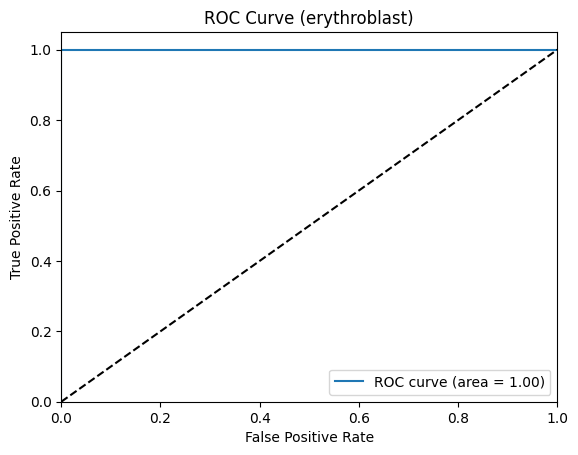

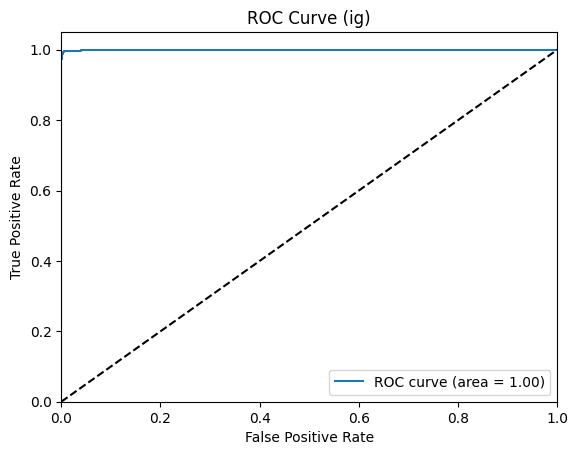

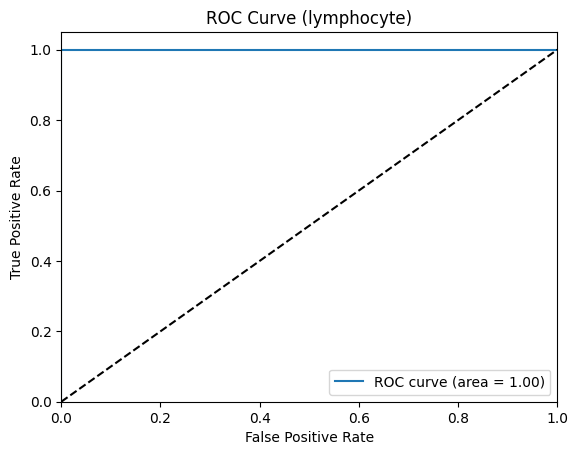

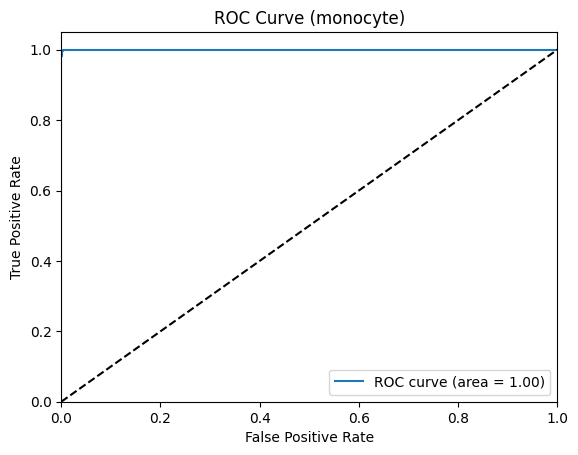

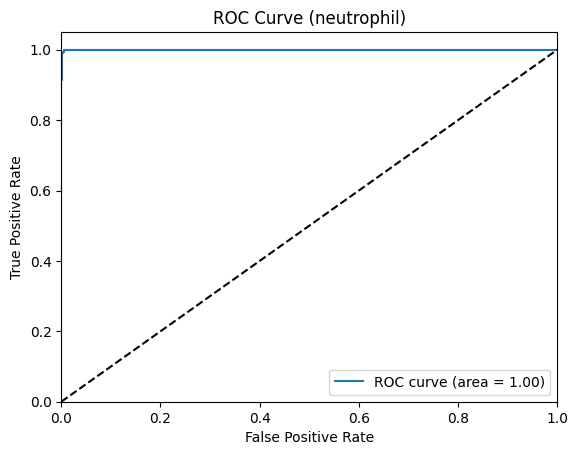

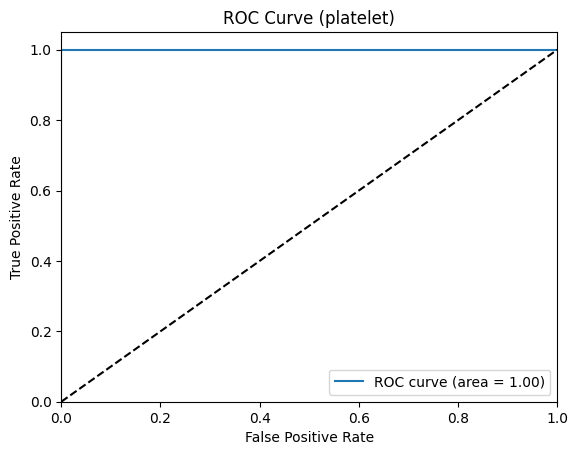

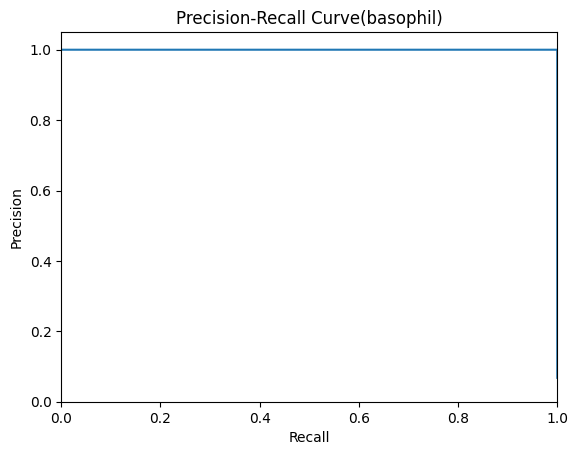

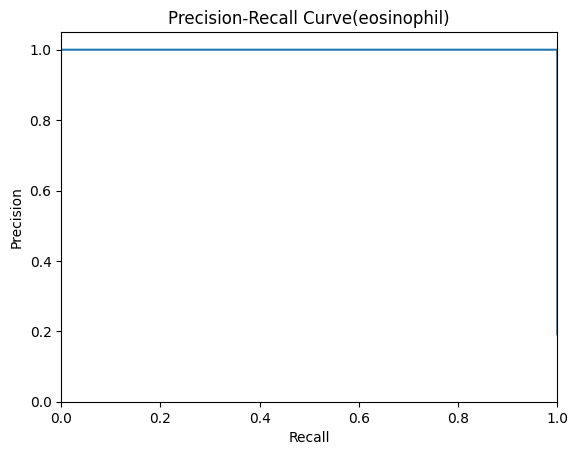

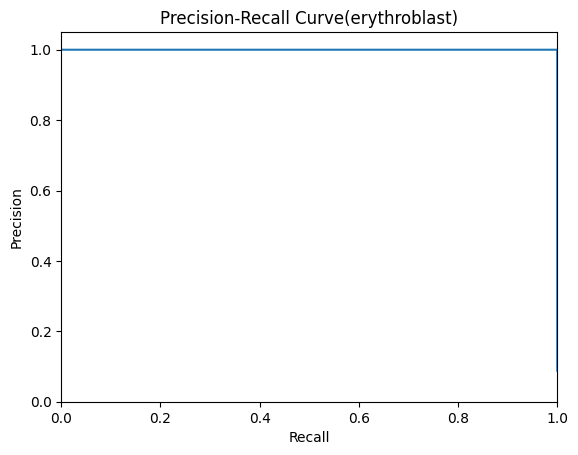

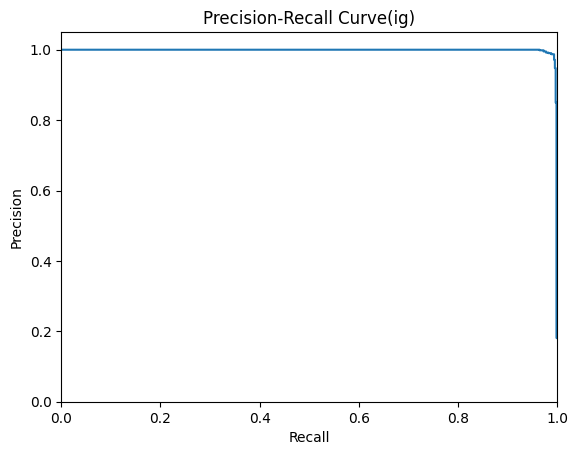

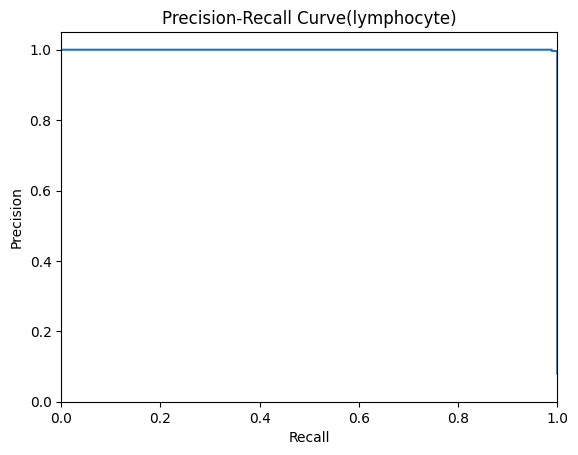

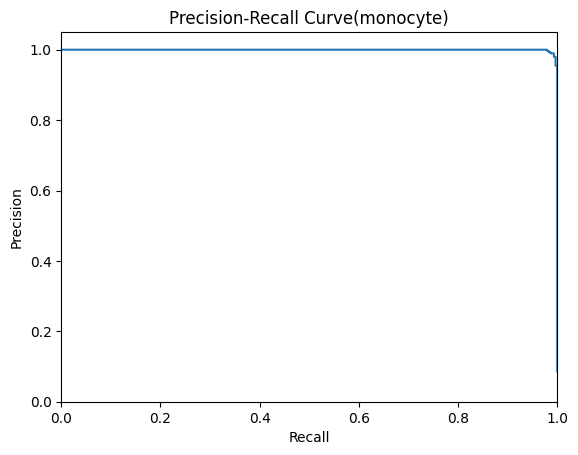

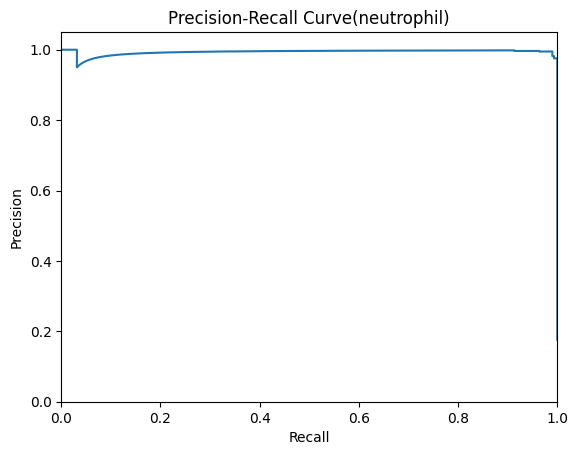

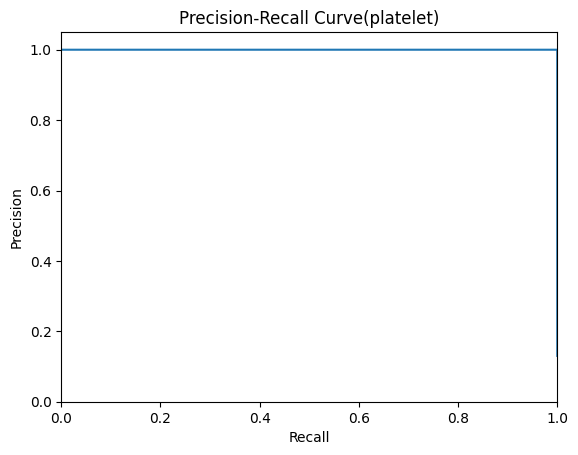

In [76]:
from sklearn.svm import SVC
model4 = SVC(kernel='linear', gamma=5, probability=True)
evaluate_model(X_train,y_train, X_test,y_test, model4, model4.predict_proba)